# This was our Project 3 - Object Segmentation (Self-driving car) from Indonesia AI Computer Vision Bootcamp 2

## Lily Silva Ardiani - ADA LOVELACE Group


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

import seaborn as sns

import os
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from PIL import Image

In [ ]:
import zipfile

zip_path = '/content/Dataset-20230813T040826Z-001.zip'
destination_folder = '/content/Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

Load Dataset

In [ ]:
path = './Dataset'
image_path = os.path.join(path, './images_prepped_train-20230811T065243Z-001/images_prepped_train/')
mask_path = os.path.join(path, './annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

testimage_path = os.path.join(path, './images_prepped_test-20230811T065241Z-001/images_prepped_test/')
testmask_path = os.path.join(path, './annotations_prepped_test-20230811T065240Z-001/annotations_prepped_test/')
testimage_list = os.listdir(testimage_path)
testmask_list = os.listdir(testmask_path)
testimage_list = [testimage_path+i for i in testimage_list]
testmask_list = [testmask_path+i for i in testmask_list]


In [ ]:
print("Number of images train:", len(image_list))
print("Number of masks train:", len(mask_list))

print("Number of images test:", len(testimage_list))
print("Number of masks test:", len(testmask_list))

Number of images train: 398
Number of masks train: 367
Number of images test: 101
Number of masks test: 101


<ipython-input-5-c37ce74a84a2>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
<ipython-input-5-c37ce74a84a2>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

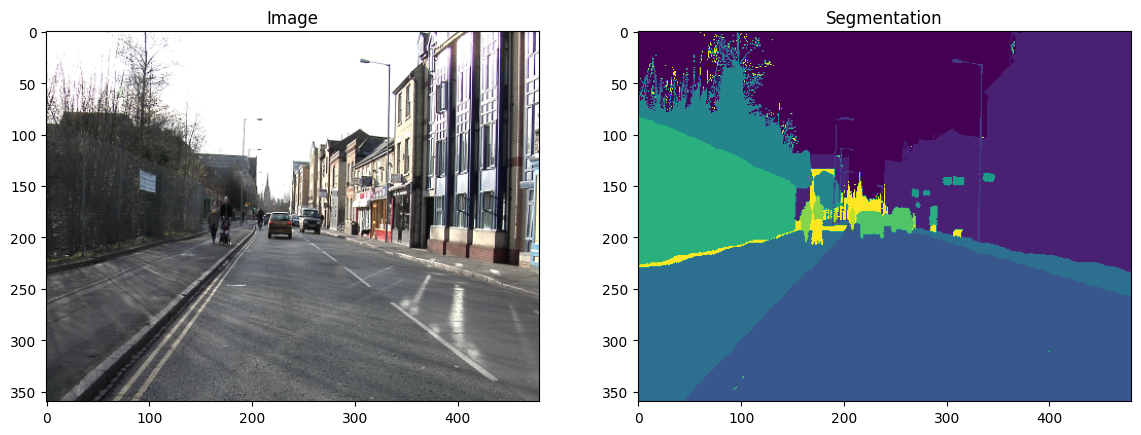

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

Duplicate photos example:
0006R0_f03690(1).png
0006R0_f03690.png
0016E5_07710(1).png
0016E5_07710.png
0016E5_07710(2).png
0016E5_07800(1).png
0016E5_07800(2).png
0016E5_07800.png
Total duplicate photos: 31


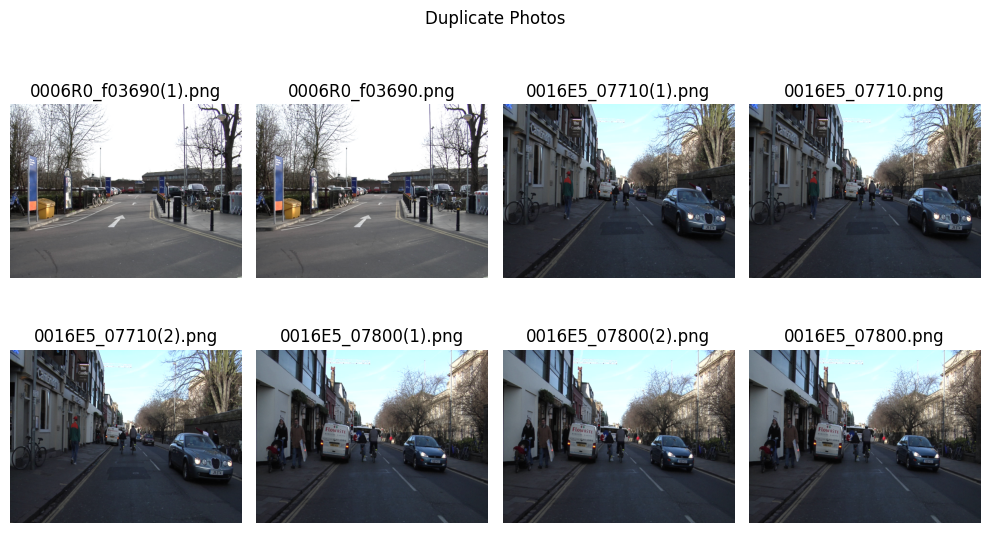

In [ ]:
import hashlib

# Check all image file types
image_files = [file for file in os.listdir(image_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Dictionary duplicate files
duplicate_files = {}

# Check all images
for file_name in image_files:
    file_path = os.path.join(image_path, file_name)
    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()

    if file_hash not in duplicate_files:
        duplicate_files[file_hash] = [file_name]
    else:
        duplicate_files[file_hash].append(file_name)

# Total duplicate files
total_duplicate_files = sum(len(files) - 1 for files in duplicate_files.values())

# Show the duplicate files
print("Duplicate photos example:")
count = 0
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        for file_name in file_list[:8]:
            count += 1
            print(file_name)
            if count == 8:
                break
    if count == 8:
        break

# Show total duplicate files
print(f"Total duplicate photos: {total_duplicate_files}")

# Collect the duplicate files
duplicate_examples = []
for file_list in duplicate_files.values():
    if len(file_list) > 1:
        duplicate_examples.extend(file_list[:8])
    if len(duplicate_examples) >= 10:
        break

# Show the duplicate files
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    if i < len(duplicate_examples):
        file_name = duplicate_examples[i]
        file_path = os.path.join(image_path, file_name)
        image = plt.imread(file_path)
        ax.imshow(image)
        ax.set_title(file_name)
        plt.suptitle('Duplicate Photos')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from collections import Counter

# Count the occurrences of each image filename
image_filename_counts = Counter([os.path.basename(image_filename) for image_filename in image_list])

# Create filtered lists excluding duplicate filenames
filtered_image_list = []
filtered_mask_list = []

for image_filename, mask_filename in zip(image_list, mask_list):
    base_image_filename = os.path.basename(image_filename)

    # Check if the image filename occurs only once (not a duplicate)
    if image_filename_counts[base_image_filename] == 1:
        filtered_image_list.append(image_filename)
        filtered_mask_list.append(mask_filename)

# Create the TensorFlow Dataset using the filtered lists
dataset = tf.data.Dataset.from_tensor_slices((filtered_image_list, filtered_mask_list))
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0016E5_04560.png', shape=(), dtype=string)
tf.Tensor(b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0016E5_04560.png', shape=(), dtype=string)


In [ ]:
import os
import shutil

# Define paths
filtered_data_path = os.path.join(path, 'filtered_data')
filtered_images_path = os.path.join(filtered_data_path, 'filtered_images')
filtered_masks_path = os.path.join(filtered_data_path, 'filtered_masks')

# Create the filtered data folder if it doesn't exist
os.makedirs(filtered_images_path, exist_ok=True)
os.makedirs(filtered_masks_path, exist_ok=True)

# Copy or move the filtered images and masks to the new folder
for image_filename in filtered_image_list:
    base_image_filename = os.path.basename(image_filename)
    base_mask_filename = os.path.splitext(base_image_filename)[0] + '_mask.png'  # Add "_mask" to image filename

    image_destination = os.path.join(filtered_images_path, base_image_filename)
    mask_destination = os.path.join(filtered_masks_path, base_mask_filename)

    shutil.copy(image_filename, image_destination)  # Use shutil.move if you want to move the files
    shutil.copy(mask_filename, mask_destination)    # Use shutil.move if you want to move the files

print("Filtered images and masks have been copied to the 'filtered_data' folder.")

Filtered images and masks have been copied to the 'filtered_data' folder.


In [ ]:
print("Number of images:", len(filtered_image_list))
print("Number of masks:", len(filtered_mask_list))

Number of images: 367
Number of masks: 367


In [ ]:
import os

# Define paths
filtered_data_path = './Dataset/filtered_data'
filtered_images_path = './Dataset/filtered_data/filtered_images'
filtered_masks_path = './Dataset/filtered_data/filtered_masks'
files =os.listdir(filtered_data_path)
image_files =os.listdir(filtered_images_path)
mask_files =os.listdir(filtered_masks_path)
print('Total filtered files: ', len(files))
print('Total filtered image: ', len(image_files))
print('Total filtered mask: ', len(mask_files))

Total filtered files:  2
Total filtered image:  367
Total filtered mask:  367


<ipython-input-11-d3055b5c0930>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filtered_image_list[N])
<ipython-input-11-d3055b5c0930>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(filtered_mask_list[N])


Text(0.5, 1.0, 'Segmentation')

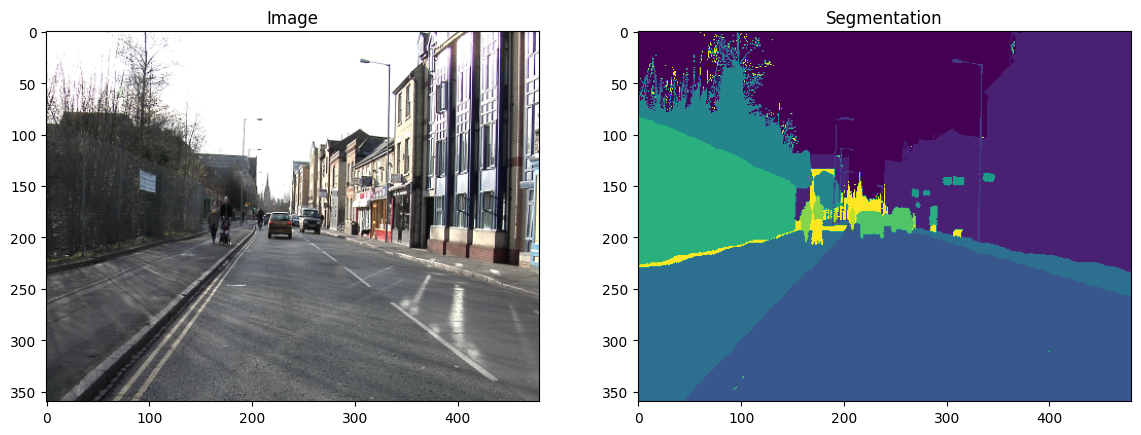

In [ ]:
N = 2
img = imageio.imread(filtered_image_list[N])
mask = imageio.imread(filtered_mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(filtered_image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(filtered_mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)


(<tf.Tensor: shape=(), dtype=string, numpy=b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0001TP_006690.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0001TP_006690.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0001TP_006750.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0001TP_006720.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0001TP_006780.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0001TP_006750.png'>)


In [ ]:
# Create pairs of image and mask filenames
paired_filenames = [
    (img_file, mask_file)
    for img_file in filtered_image_list
    for mask_file in filtered_mask_list
    if os.path.basename(img_file).replace("_mask", "") == os.path.basename(mask_file).replace("_mask", "")
]

# Separate the paired filenames into image and mask lists
paired_image_filenames = [pair[0] for pair in paired_filenames]
paired_mask_filenames = [pair[1] for pair in paired_filenames]

# Create TensorFlow Datasets from the paired filenames
image_filenames = tf.constant(paired_image_filenames)
mask_filenames = tf.constant(paired_mask_filenames)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0016E5_04560.png', shape=(), dtype=string)
tf.Tensor(b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0016E5_04560.png', shape=(), dtype=string)


In [ ]:
for i in range(10):
  item1=image_filenames[i % len(image_filenames)]
  item2=mask_filenames[i % len(image_filenames)]
  print(f"{item1} - {item2}")

b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0016E5_04560.png' - b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0016E5_04560.png'
b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0016E5_00990.png' - b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0016E5_00990.png'
b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0016E5_01650.png' - b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0016E5_01650.png'
b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0016E5_04680.png' - b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0016E5_04680.png'
b'./Dataset/./images_prepped_train-20230811T065243Z-001/images_prepped_train/0006R0_f02070.png' - b'./Dataset/./annotations_prepped_train-20230811T065240Z-001/annotations_prepped_train/0006R0_

Preprocess Images and Masks

In [ ]:
def process_path(filtered_image_list, filtered_mask_list):
    img = tf.io.read_file(filtered_image_list)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(filtered_mask_list)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))

print("Number of classes: ", uniques)


Number of classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


In [ ]:
print('Number of classes ', len(uniques))

Number of classes  12


In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(360, 480, 1)


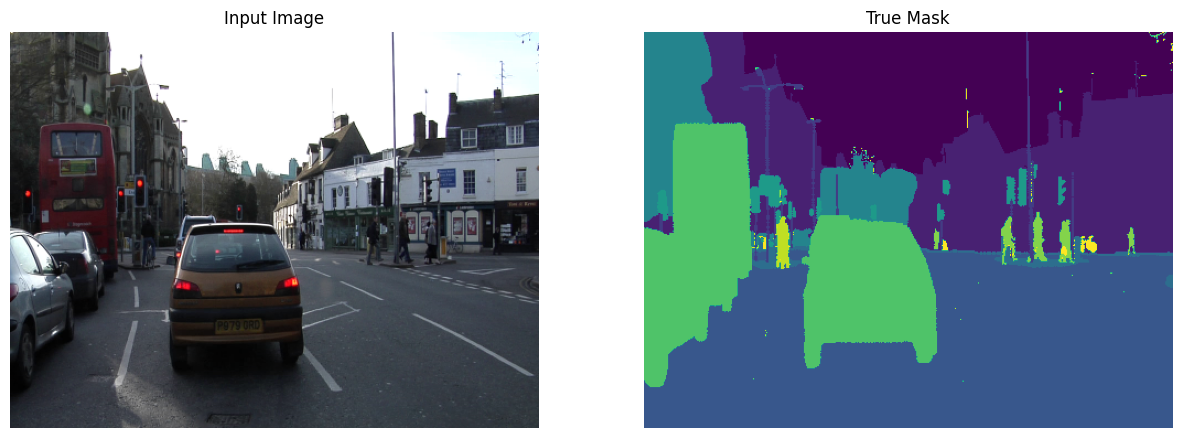

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(192, 256, 1)


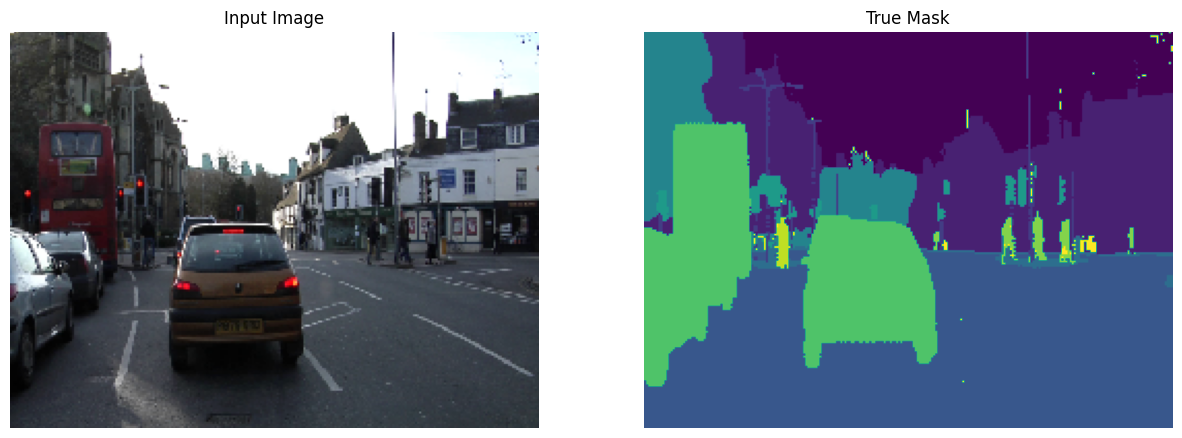

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

Encoder

In [ ]:
def conv_block(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)

    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

Decoder

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=128):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    up = Conv2DTranspose(filters=n_filters, # Number of filters
                         kernel_size=3, # Kernel size
                         strides=(2,2),
                         padding='same')(expansive_input)

    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    return conv

Build the model

In [ ]:
def unet_model(input_size=(192,256, 3), n_filters=32, n_classes=12):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)

    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3,max_pooling=False)

    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4 )
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same', activation='softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = 192
img_width = 256
num_channels = 3
num_classes = 12

unet = unet_model((img_height, img_width, num_channels), num_classes)

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 12  336         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 192, 256, 12  1308        ['conv2d[0][0]']                 
                                )                                                             

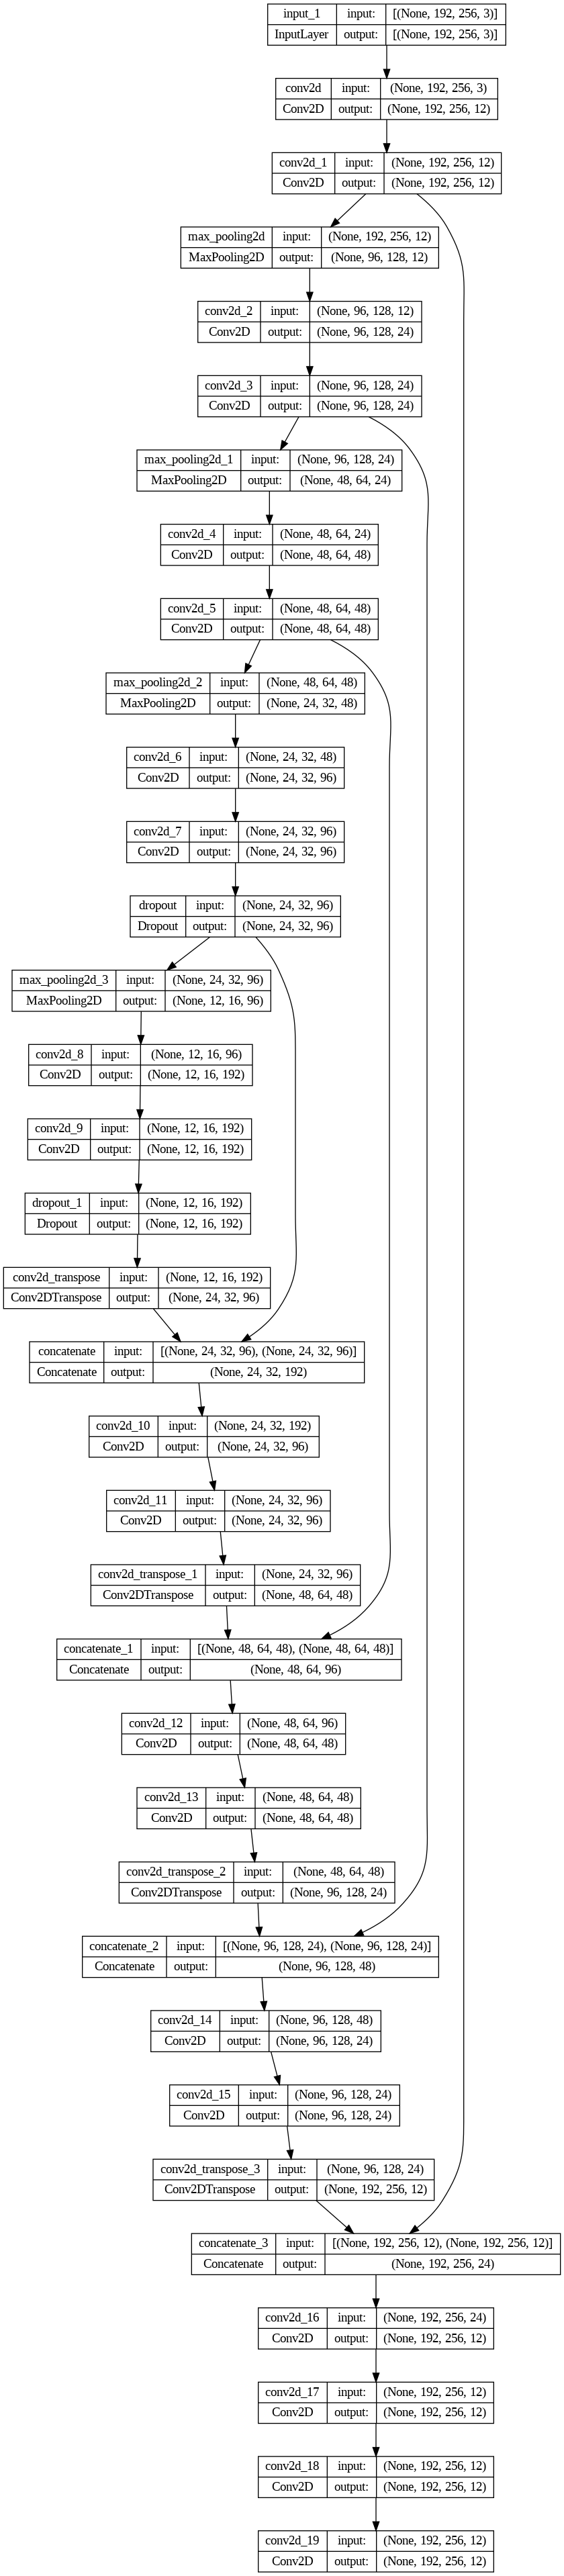

In [ ]:
tf.keras.utils.plot_model(unet, show_shapes = True)

Compile model

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training Model

In [ ]:
EPOCHS = 125
BUFFER_SIZE = 300
BATCH_SIZE = 1

map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples))
print(processed_image_ds)
# ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=1, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [ ]:
print(f'There are {len(train_dataset)} images in the Training Set')
print(f'There are {len(val_dataset)} images in the Validation Set')

There are 269 images in the Training Set
There are 68 images in the Validation Set


In [ ]:
import time
start_time = time.time()

model_history = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr])
training_time = time.time() - start_time

print("Total training time: {:.2f} seconds".format(training_time))
print("Total training time: {:.2f} hours".format(training_time/3600))

Epoch 1/125


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


269/269 [==============================] - 23s 17ms/step - loss: 1.8622 - accuracy: 0.3577 - val_loss: 1.4418 - val_accuracy: 0.5375 - lr: 0.0010
Epoch 2/125
269/269 [==============================] - 4s 14ms/step - loss: 1.2984 - accuracy: 0.5655 - val_loss: 1.1299 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 3/125
269/269 [==============================] - 4s 14ms/step - loss: 1.1215 - accuracy: 0.6440 - val_loss: 1.0876 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 4/125
269/269 [==============================] - 4s 16ms/step - loss: 1.0666 - accuracy: 0.6519 - val_loss: 1.1126 - val_accuracy: 0.6269 - lr: 0.0010
Epoch 5/125
269/269 [==============================] - 4s 13ms/step - loss: 1.0340 - accuracy: 0.6566 - val_loss: 1.0473 - val_accuracy: 0.6410 - lr: 0.0010
Epoch 6/125
269/269 [==============================] - 4s 16ms/step - loss: 1.0605 - accuracy: 0.6566 - val_loss: 0.9977 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 7/125
269/269 [==============================] - 4s 16ms/step -

Plot Model Accuracy

Accuracy
Max accuracy:  75.34 %
Mean accuracy:  73.55 %
Standard deviation accuracy: 0.04

Validation Accuracy
Max validation accuracy:  76.91 %
Mean validation accuracy:  73.73 %
Standard deviation accuracy: 0.03

Loss
Min loss:  73.69 %
Mean loss:  78.26 %
Standard deviation loss: 0.12

Validation Loss
Min validation loss:  70.46 %
Mean validation loss:  78.09 %
Standard deviation validation loss: 0.09


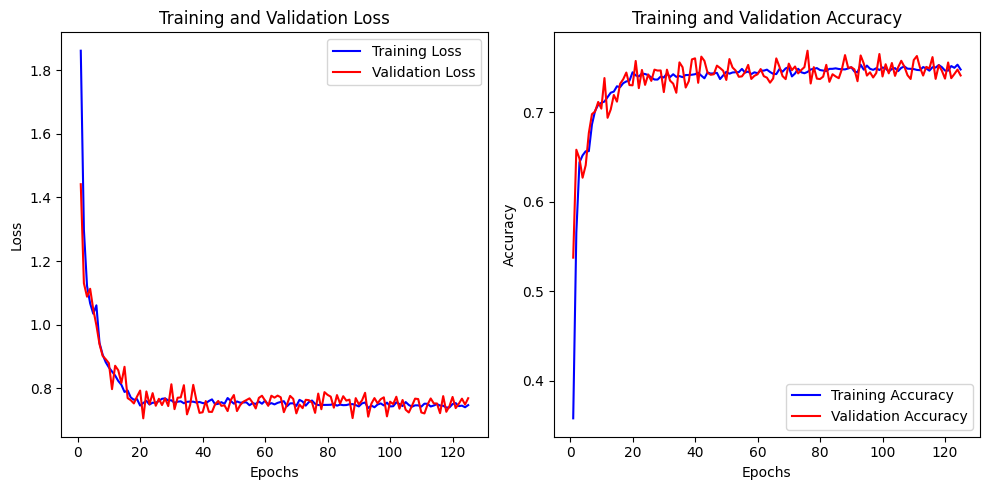

In [ ]:
def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)
    print("Accuracy")
    print("Max accuracy:  %.2f" % (np.max(train_accuracy)*100), "%")
    print("Mean accuracy:  %.2f" % (np.mean(train_accuracy)*100), "%")
    print("Standard deviation accuracy: %.2f" % np.std(train_accuracy))

    print("")

    print("Validation Accuracy")
    print("Max validation accuracy:  %.2f" % (np.max(val_accuracy)*100), "%")
    print("Mean validation accuracy:  %.2f" % (np.mean(val_accuracy)*100), "%")
    print("Standard deviation accuracy: %.2f" % np.std(val_accuracy))

    print("")

    print('Loss')
    print("Min loss:  %.2f" % (np.min(train_loss)*100), "%")
    print("Mean loss:  %.2f" % (np.mean(train_loss)*100), "%")
    print("Standard deviation loss: %.2f" % np.std(train_loss))

    print("")

    print('Validation Loss')
    print("Min validation loss:  %.2f" % (np.min(val_loss)*100), "%")
    print("Mean validation loss:  %.2f" % (np.mean(val_loss)*100), "%")
    print("Standard deviation validation loss: %.2f" % np.std(val_loss))

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_loss_and_accuracy(model_history)


Create Predicted Masks

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

Show Predictions

In [ ]:
def show_predictions(unet=unet, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 299ms/step


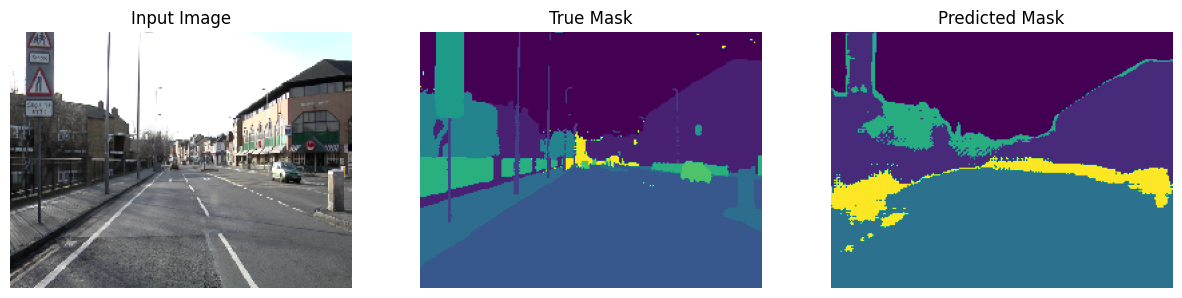

1/1 [==============================] - 0s 26ms/step


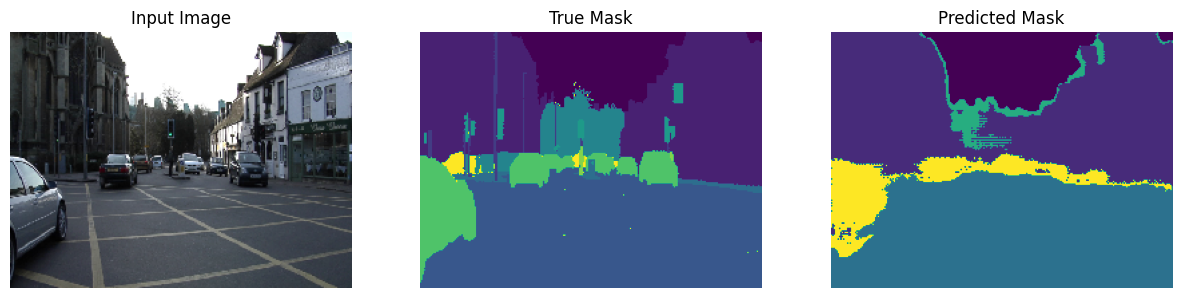

1/1 [==============================] - 0s 27ms/step


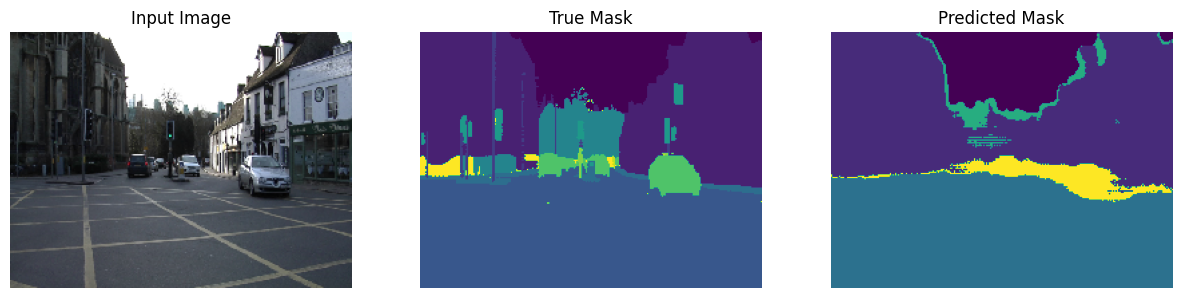

1/1 [==============================] - 0s 36ms/step


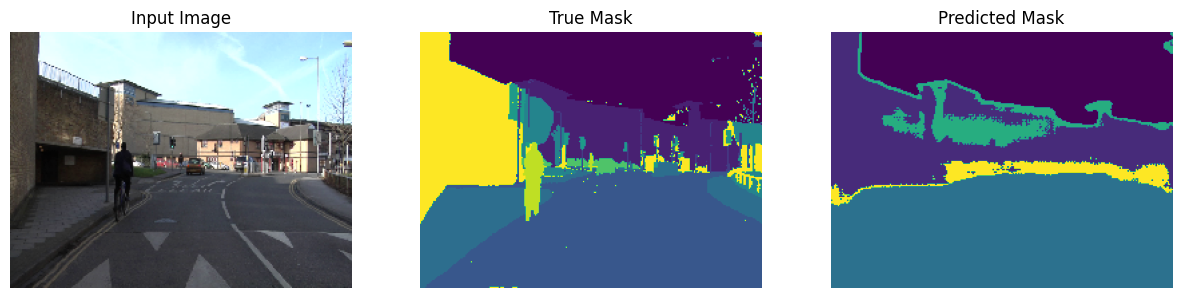

1/1 [==============================] - 0s 21ms/step


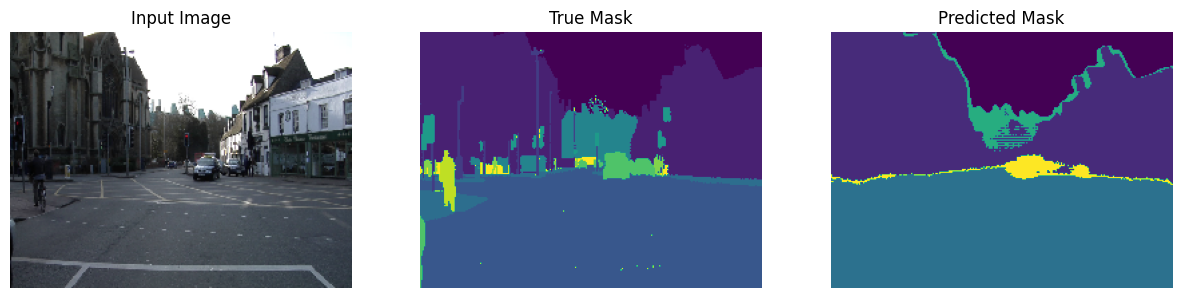

1/1 [==============================] - 0s 30ms/step


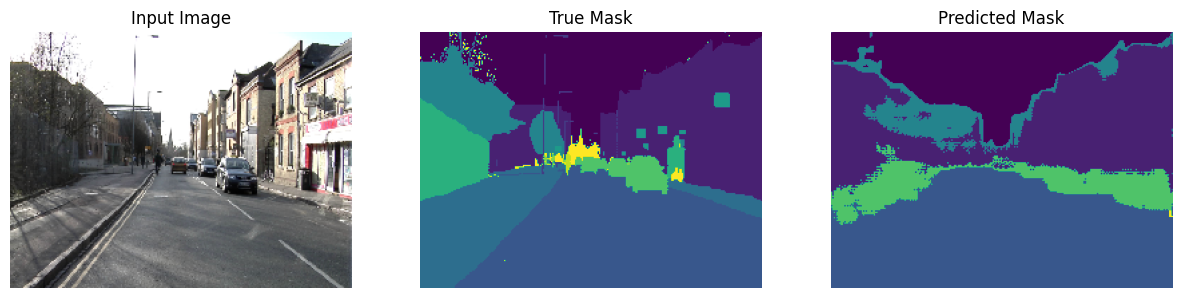

1/1 [==============================] - 0s 26ms/step


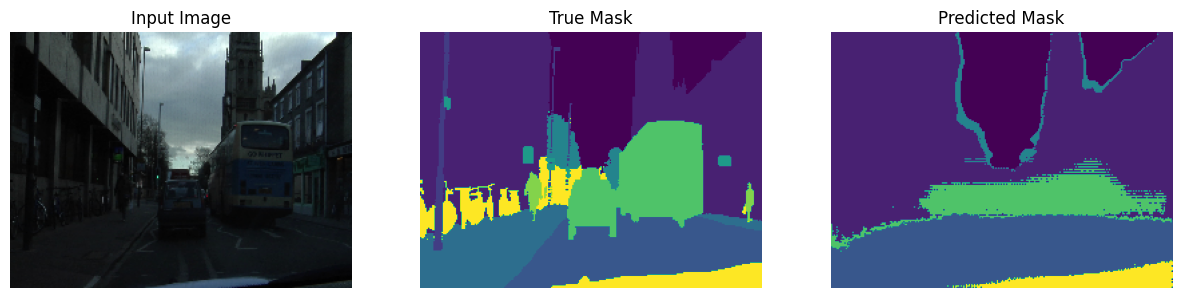

1/1 [==============================] - 0s 29ms/step


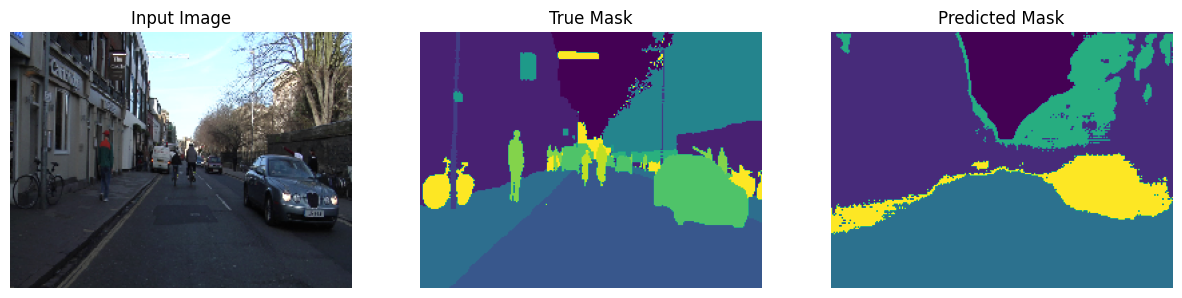

In [ ]:
show_predictions(unet, train_dataset, 8)

1/1 [==============================] - 0s 22ms/step


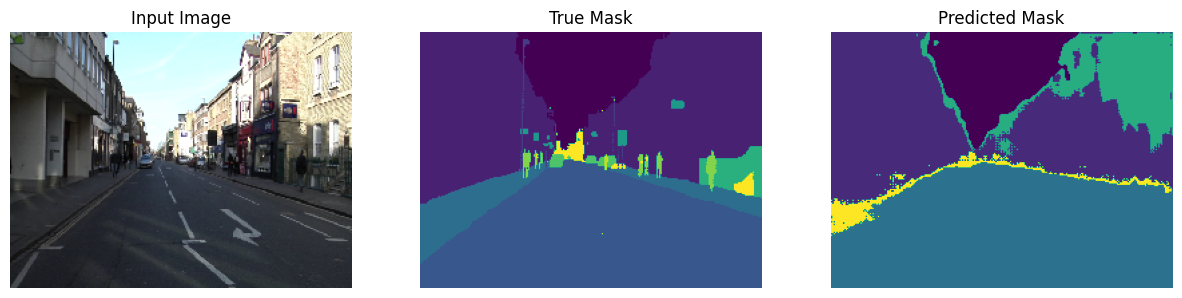

1/1 [==============================] - 0s 21ms/step


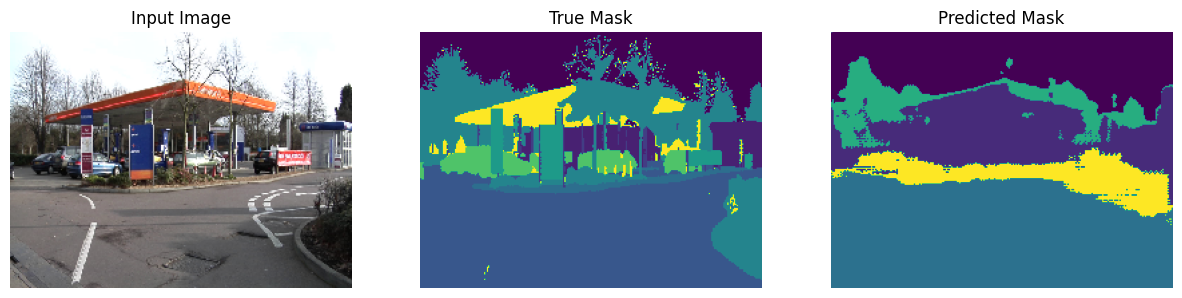

1/1 [==============================] - 0s 35ms/step


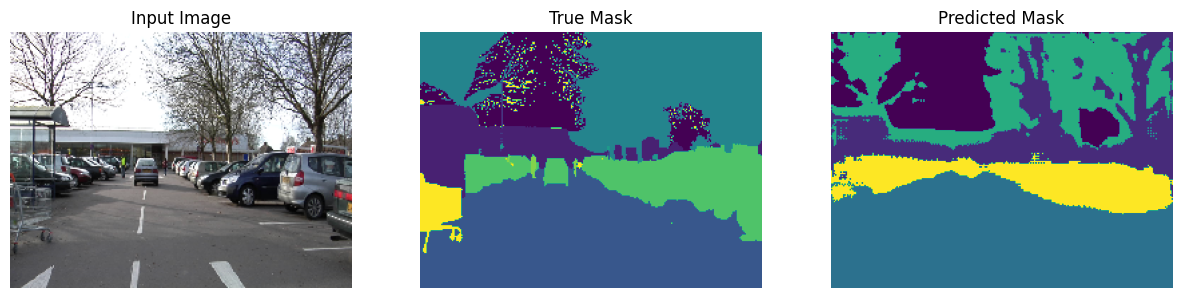

1/1 [==============================] - 0s 39ms/step


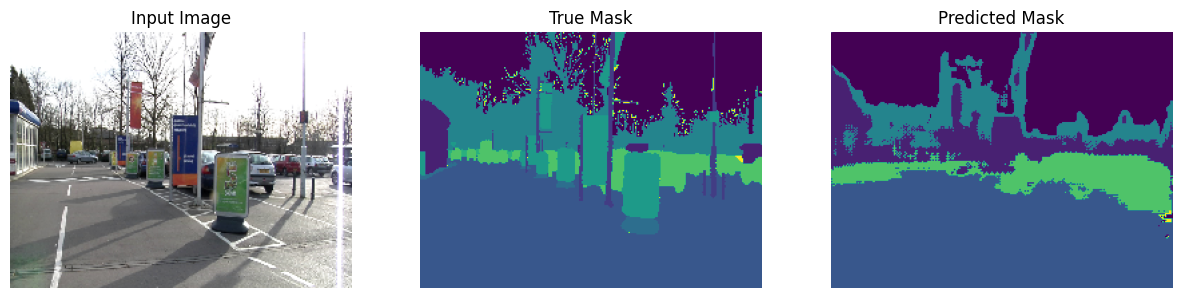

1/1 [==============================] - 0s 59ms/step


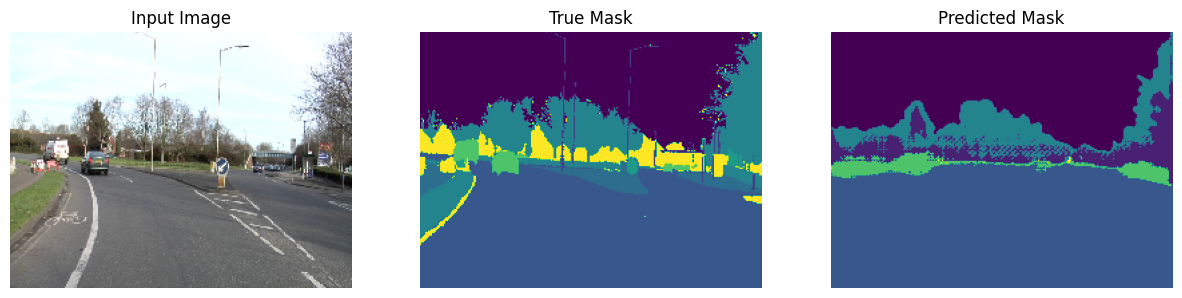

1/1 [==============================] - 0s 44ms/step


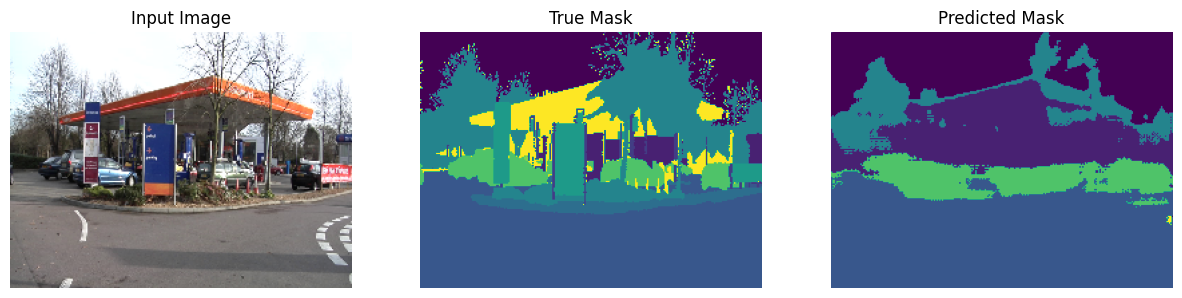

1/1 [==============================] - 0s 26ms/step


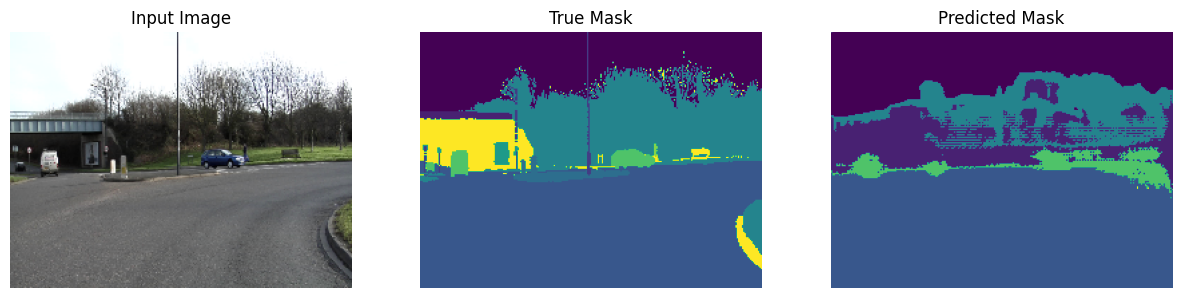

1/1 [==============================] - 0s 28ms/step


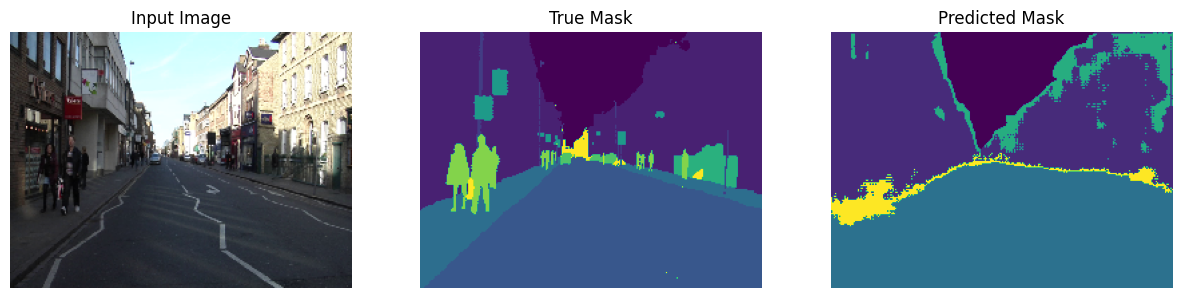

In [ ]:
show_predictions(unet, val_dataset, 8)

1/1 [==============================] - 0s 21ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 19ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 22ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 20ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 19ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 22ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 19ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 21ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [===================

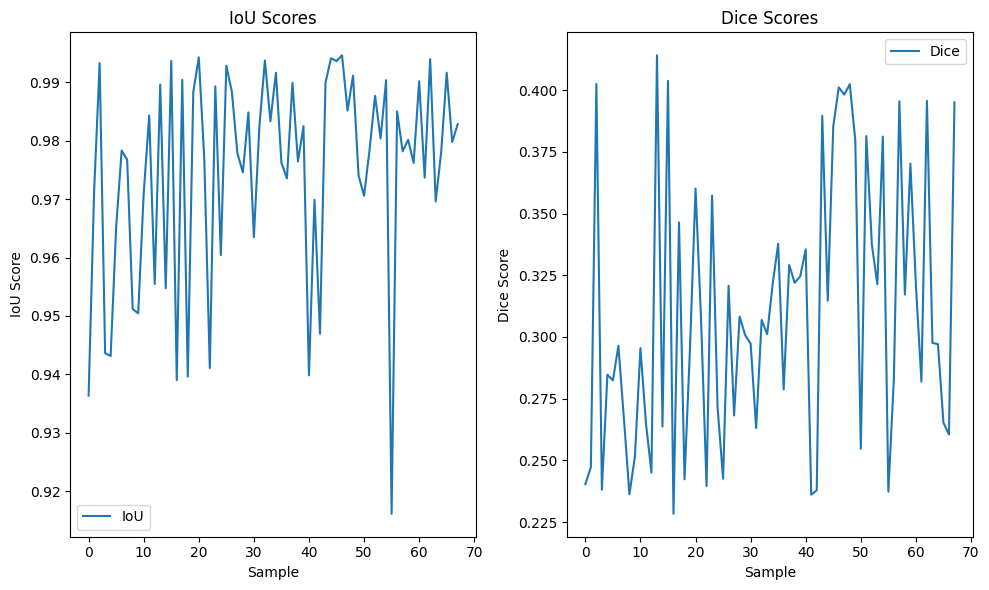

In [ ]:
import numpy as np
import tensorflow as tf

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_dice(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    dice_score = 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

iou_scores = []
dice_scores = []

for images, masks_true in val_dataset:
    masks_pred = unet.predict(images)
    masks_pred = np.argmax(masks_pred, axis=-1)  # Convert logits to class indices
    masks_pred = np.expand_dims(masks_pred, axis=-1)  # Add the channel dimension

    print("masks_true shape:", masks_true.shape)
    print("masks_pred shape:", masks_pred.shape)

    for i in range(masks_pred.shape[0]):
        iou_scores.append(calculate_iou(masks_true[i], masks_pred[i]))
        dice_scores.append(calculate_dice(masks_true[i], masks_pred[i]))

average_iou = np.mean(iou_scores)
average_dice = np.mean(dice_scores)

print("Average IoU:", average_iou)
print("Average Dice Score:", average_dice)

# Plot the IoU and Dice scores
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(iou_scores, label='IoU')
plt.xlabel('Sample')
plt.ylabel('IoU Score')
plt.title('IoU Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dice_scores, label='Dice')
plt.xlabel('Sample')
plt.ylabel('Dice Score')
plt.title('Dice Scores')
plt.legend()

plt.tight_layout()
plt.show()


Test The Model

In [ ]:
# Define a function to process test dataset
def process_test_path(test_image_path, test_mask_path):
    img = tf.io.read_file(test_image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(test_mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

# Create the test dataset
test_ds = tf.data.Dataset.from_tensor_slices((testimage_list, testmask_list))
test_ds = test_ds.map(process_test_path)
test_ds = test_ds.map(preprocess)
test_ds = test_ds.batch(BATCH_SIZE)

# Now you can use the test_dataset for evaluation


In [ ]:
print(f'There are {len(test_ds)} images in the Test Set')

There are 101 images in the Test Set


1/1 [==============================] - 0s 25ms/step


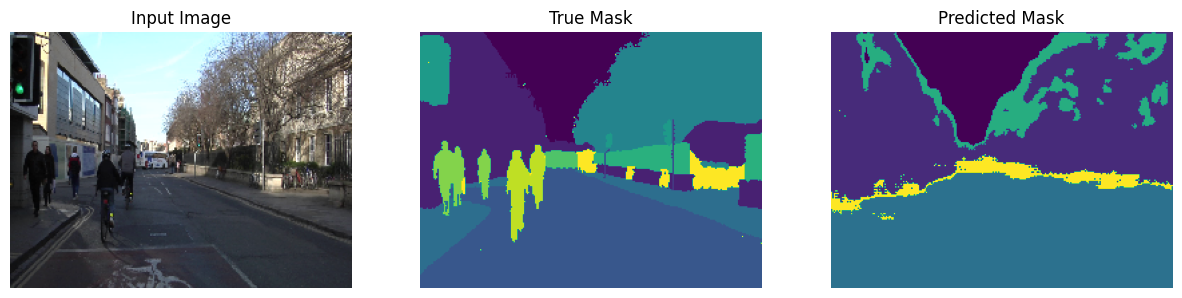

1/1 [==============================] - 0s 22ms/step


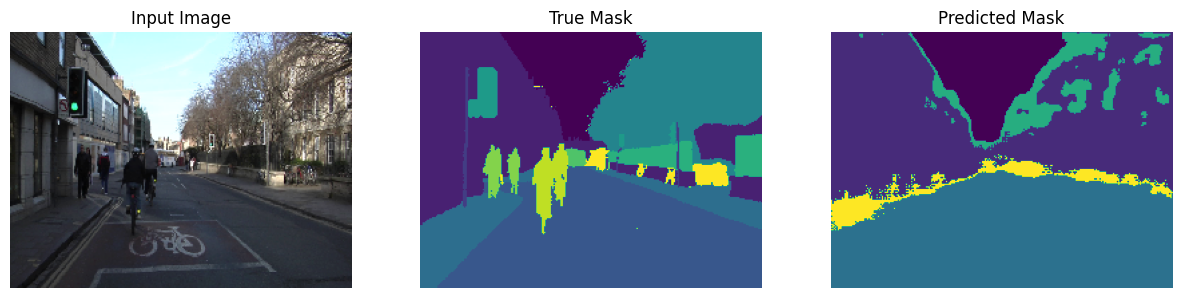

1/1 [==============================] - 0s 21ms/step


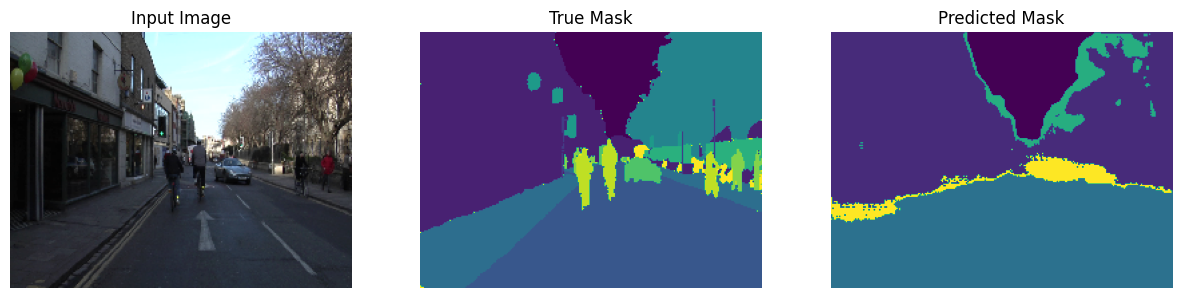

1/1 [==============================] - 0s 40ms/step


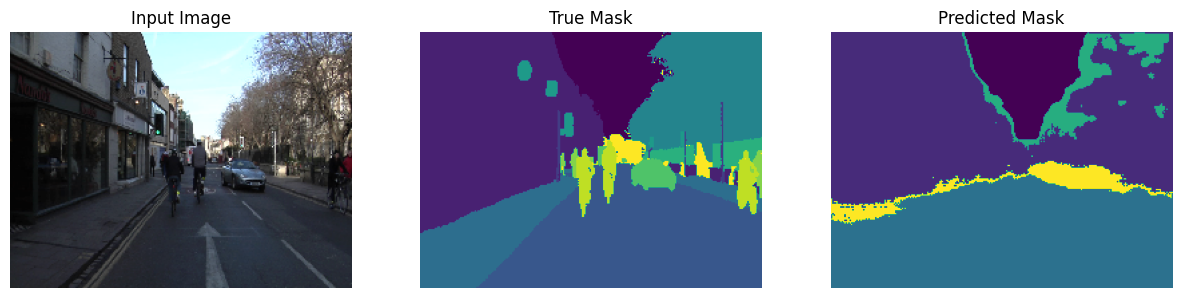

1/1 [==============================] - 0s 21ms/step


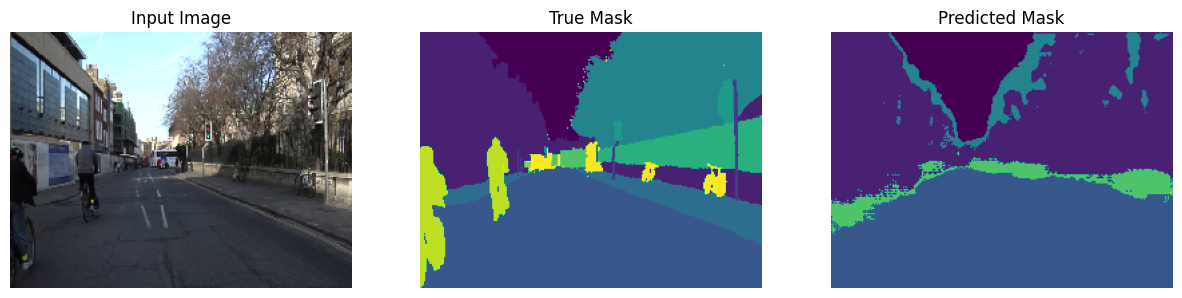

1/1 [==============================] - 0s 33ms/step


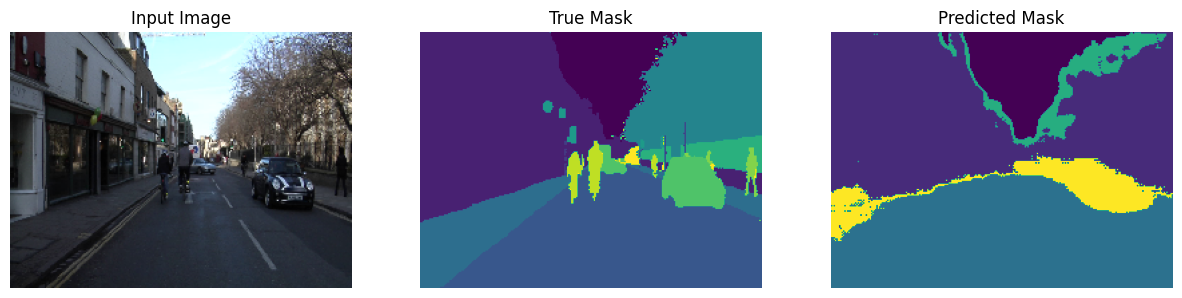

1/1 [==============================] - 0s 26ms/step


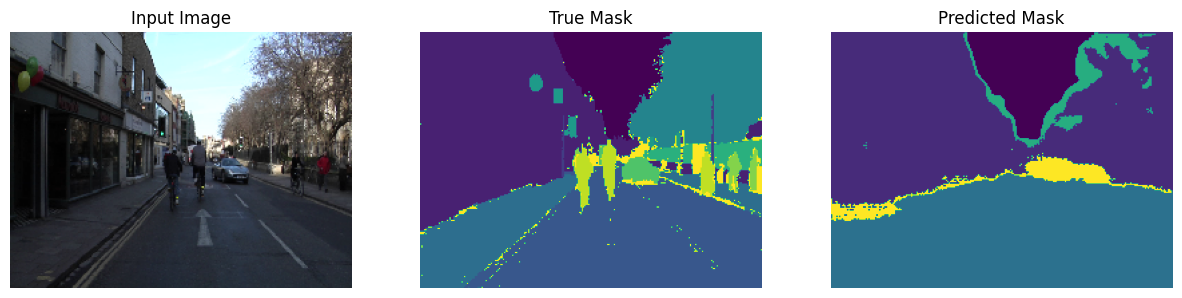

1/1 [==============================] - 0s 30ms/step


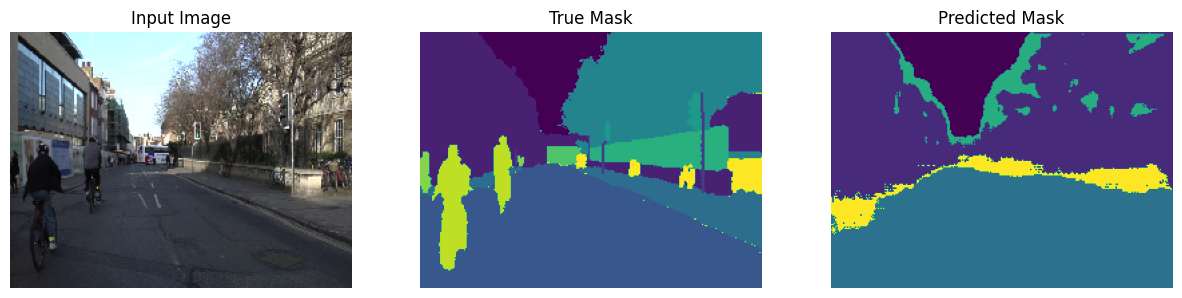

In [ ]:
show_predictions(unet, test_ds, 8)

1/1 [==============================] - 0s 102ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 95ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 30ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 20ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 21ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 29ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 24ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==============================] - 0s 24ms/step
masks_true shape: (1, 192, 256, 1)
masks_pred shape: (1, 192, 256, 1)
1/1 [==================

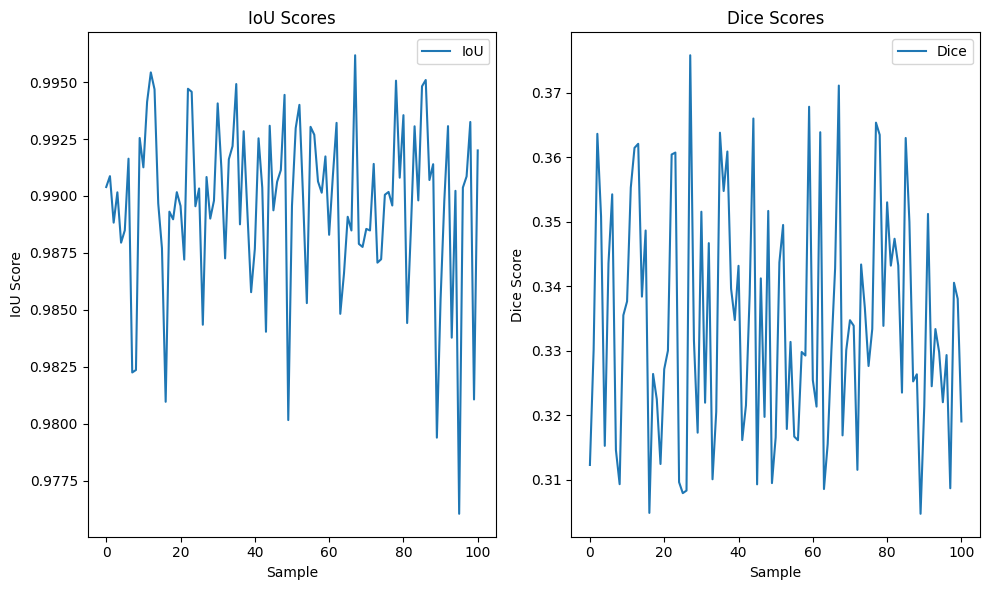

In [ ]:
iou_scores = []
dice_scores = []

for images, masks_true in test_ds:
    masks_pred = unet.predict(images)
    masks_pred = np.argmax(masks_pred, axis=-1)  # Convert logits to class indices
    masks_pred = np.expand_dims(masks_pred, axis=-1)  # Add the channel dimension

    print("masks_true shape:", masks_true.shape)
    print("masks_pred shape:", masks_pred.shape)

    for i in range(masks_pred.shape[0]):
        iou_scores.append(calculate_iou(masks_true[i], masks_pred[i]))
        dice_scores.append(calculate_dice(masks_true[i], masks_pred[i]))

average_iou = np.mean(iou_scores)
average_dice = np.mean(dice_scores)

print("Average IoU:", average_iou)
print("Average Dice Score:", average_dice)

# Plot the IoU and Dice scores
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(iou_scores, label='IoU')
plt.xlabel('Sample')
plt.ylabel('IoU Score')
plt.title('IoU Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dice_scores, label='Dice')
plt.xlabel('Sample')
plt.ylabel('Dice Score')
plt.title('Dice Scores')
plt.legend()

plt.tight_layout()
plt.show()


# References:
https://github.com/Vibhugupta10616/Semantic-Image-Segmentation-Unet/blob/main/Image%20Segmentation.ipynb

https://www.kaggle.com/code/sudoshivam/u-net-semantic-segmentation-for-self-driving-cars